<a href="https://colab.research.google.com/github/archivesunleashed/notebooks/blob/master/parquet_text_analyis_popline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Archives Unleashed Web Pages Parquet Derivative

In this notebook, we'll setup an enviroment, then download a dataset of web archive collection derivatives that were produced with the [Archives Unleashed Toolkit](https://github.com/archivesunleashed/aut/). These derivatives are in the [Apache Parquet](https://parquet.apache.org/) format, which is a [columnar storage](http://en.wikipedia.org/wiki/Column-oriented_DBMS) format. These derivatives are generally small enough to work with on your local machine.

The Parquet derivative for this notebook is the **Web Pages** one:

`.webpages().select($"crawl_date", $"url", $"mime_type_web_server", $"mime_type_tika", RemoveHTMLDF(RemoveHTTPHeaderDF(($"content"))).alias("content"))` 

Produces a DataFrame with the following columns:
  - `crawl_date`
  - `url`
  - `mime_type_web_server`
  - `mime_type_tika`
  - `language`
  - `content`

We recommend running through the notebook with the provided sample dataset. You may then want to substitute it with your own dataset.

# Dataset

First, we will need a web archive dataset to work with.

In this example notebook, we use a dataset from [Bibliothèque et Archives nationales du Québec](https://www.banq.qc.ca/accueil/). It is a web archive collection of the Ministry of Environment of Québec (2011-2014), that has been  processed by the [Archives Unleashed Toolkit](https://github.com/archivesunleashed/aut/). Merci beaucoup BAnQ!

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3633022.svg)](https://doi.org/10.5281/zenodo.3633022)

Curious about the size of the derivative Parquet output compared to the size of the web archive collection?

The total size of all 12 Parquet deriatives is 594M, with `webpages` being the largest (525M) since it has a column with full text (`content`).

```
1.6M    ./presentation-program-files
1.4M    ./video
473M    ./webpages
108K    ./spreadsheet
3.0M    ./images
1.7M    ./pdf
780K    ./word-processor
540K    ./text-files
21M     ./imagelinks
112K    ./audio
103M    ./webgraph
240K    ./domains
604M    .
```

The total size of the web archive collection is 165G. The derivative file is thus a 99.68% decrease!

The following command downloads all of the parquets file from the Zenodo data repository. To run a 'cell,' you can click the play button next to the cell or you can press your `shift` key and `enter` key at the same time.

Whenever you see code snippets like this, you should do the same thing to run it.

In [0]:
%%capture

!curl -L "https://zenodo.org/record/3633022/files/ivy-12006-parquet.tar.gz?download=1" > ivy-12006-parquet.tar.gz
!tar -xzf ivy-12006-parquet.tar.gz

The following command provides a list of all the downloaded parquet files. You should see `webpages` in there. That's what we'll be working with!

In [2]:
!ls -1 parquet

audio
domains
imagelinks
images
pdf
presentation-program-files
spreadsheet
text-files
video
webgraph
webpages
word-processor


# Environment

Next, we'll setup our environment so we can work with the Parquet output with PySpark. We use PySpark a lot here in the first part of the notebook because of the computationally intense nature of the work we are doing. 

This can be seen as a use case for when to turn to PySpark over Pandas, since we need to take full advantage of the limited compute resources available in Google Colab to do tokenization. Running the tokenization on the DataFrame in parallel with PySpark and MLlib takes a few seconds, whereas running the tokenization with Pandas and NLTK takes ~26 minutes. Using spaCy results in the notebook timing out -- it is simply too big!

Later in the notebook, we'll take advantage of being able to convert a PySpark DataFrame to a Pandas DataFrame to plot some items, and create a word cloud.

Confused? It's just important to remember that PySpark does the heavy computational lifting --- helping you get your data small enough that Pandas can begin to step in.

### Setup PySpark

The following commands download and install PySpark.

In [0]:
%%capture

!apt-get update
!apt-get install -y openjdk-8-jdk-headless -qq 
!apt-get install maven -qq

!curl -L "https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz" > spark-2.4.5-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").config("spark.driver.memory", "35g").config("spark.driver.maxResultSize", "0").config("spark.sql.execution.arrow.enabled", "true").getOrCreate()

# Loading our pages derivative as a DataFrame

Now that PySpark is set up and the `webpages` parquet file is on our system, it's time to work with it.

We'll start by loading up the dataset to work with, and show a preview so we can get an overview of what's there and importantly, make sure that everything is working. 

Notice in the output below we have a mix of French and English content.

In [6]:
pages = spark.read.parquet("parquet/webpages")
pages.show()

+----------+--------------------+--------------------+--------------+--------+--------------------+
|crawl_date|                 url|mime_type_web_server|mime_type_tika|language|             content|
+----------+--------------------+--------------------+--------------+--------+--------------------+
|  20190823|https://www.faceb...|           text/html|     text/html|      en|Facebook Facebook...|
|  20190823|https://www.linke...|           text/html|     text/html|      en|LinkedIn LinkedIn...|
|  20190823|https://mix.com/m...|           text/html|     text/html|      en|Mix · Learn More ...|
|  20190823|https://www.mheal...|           text/html|     text/html|      en|Search results | ...|
|  20190823|https://accounts....|           text/html|     text/html|      en|Google Bookmarks ...|
|  20190823|https://twitter.c...|           text/html|     text/html|      en|Share a link on T...|
|  20190823|https://www.reddi...|           text/html|     text/html|      en|reddit.com: Log i...|


In [7]:
pages.count()

248062

## Text Analysis

With the `pages` derivative, we get a `content` column. This is the text of the web page, with the HTTP header information stripped out. Since we have this column, it opens up the whole world of text analysis to us!


Let's start the text analysis section by installing and importing some helpful [MLlib libraries](https://spark.apache.org/docs/2.4.4/ml-features.html#tokenizer).

In [0]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StopWordsRemover

### Language DataFrames

Here we are going to create two new DataFrames from `pages`; `french_pages` and `english_pages`.

### Tokenization

Let's add a new column to our `pages` DataFrame that is the tokenized output of the `text` column.

Tokenization is breaking a string of text apart into its constituative 'tokens.' For more, see https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization. 

The following commands create two new variables - one with French pages, and one with English pages. We also count them below so you can see how many of each are in the collection.


Next, we can add some tokenization columns to each of these new DataFrames.

First, we'll setup the tokenizer, so we can use it on multiple DataFrames. 

In [0]:
tokenizer = Tokenizer(inputCol="content", outputCol="tokenized_content")
countTokens = udf(lambda tokenized_content: len(tokenized_content), IntegerType())


Now, let's run it it on each of the French and English DataFrames, and add the tokens count column as well.

In [10]:
tokenized = tokenizer.transform(pages)\
                      .select("crawl_date", "content", "url", "tokenized_content")\
                      .withColumn("tokens", countTokens(col("tokenized_content")))

tokenized.show()

+----------+--------------------+--------------------+--------------------+------+
|crawl_date|             content|                 url|   tokenized_content|tokens|
+----------+--------------------+--------------------+--------------------+------+
|  20190823|Facebook Facebook...|https://www.faceb...|[facebook, facebo...|    18|
|  20190823|LinkedIn LinkedIn...|https://www.linke...|[linkedin, linked...|    27|
|  20190823|Mix · Learn More ...|https://mix.com/m...|[mix, · learn, mo...|  5431|
|  20190823|Search results | ...|https://www.mheal...|[search, results,...|   264|
|  20190823|Google Bookmarks ...|https://accounts....|[google, bookmark...|   120|
|  20190823|Share a link on T...|https://twitter.c...|[share, a, link, ...|    69|
|  20190823|reddit.com: Log i...|https://www.reddi...|[reddit.com:, log...|    44|
|  20190823|Mix · Learn More ...|https://mix.com/m...|[mix, · learn, mo...|  5088|
|  20190823|Facebook Facebook...|https://www.faceb...|[facebook, facebo...|    18|
|  2

### Stop words?

We may want to remove "stop words," which are the most common words in a language that might not be useful to our analysis. For more on stop words, see https://en.wikipedia.org/wiki/Stop_words. 

The following commands load up default stopword lists for both French and English, and remove them from the token lists.

In [11]:
StopWordsRemover.loadDefaultStopWords('english')

remover = StopWordsRemover(inputCol="tokenized_content", outputCol="tokenized_content_filtered")

stopwords = remover.transform(tokenized).withColumn("filted_tokens", countTokens(col("tokenized_content_filtered")))

stopwords.show()

+----------+--------------------+--------------------+--------------------+------+--------------------------+-------------+
|crawl_date|             content|                 url|   tokenized_content|tokens|tokenized_content_filtered|filted_tokens|
+----------+--------------------+--------------------+--------------------+------+--------------------------+-------------+
|  20190823|Facebook Facebook...|https://www.faceb...|[facebook, facebo...|    18|      [facebook, facebo...|           14|
|  20190823|LinkedIn LinkedIn...|https://www.linke...|[linkedin, linked...|    27|      [linkedin, linked...|           24|
|  20190823|Mix · Learn More ...|https://mix.com/m...|[mix, · learn, mo...|  5431|      [mix, · learn, jo...|         3132|
|  20190823|Search results | ...|https://www.mheal...|[search, results,...|   264|      [search, results,...|          194|
|  20190823|Google Bookmarks ...|https://accounts....|[google, bookmark...|   120|      [google, bookmark...|          108|
|  20190

### Basic word count statistics with PySpark!

The following set of commands provides some basic information on the words found within the web archive: maximum, mean, and minimum number of words throughout the collection.

The idea here is to get a sense of how to run some basic statistics available to us in PySpark, and maybe inspire additional questions to ask a dataset like this. 

Also, take note as to how long each one takes here, since we'll do the same below with Pandas. Which one will be faster?


In [0]:
from pyspark.sql.functions import col, avg, stddev, mean, max, min

#### Mean

In [13]:
stopwords.select(mean('tokens')).show()

+-----------------+
|      avg(tokens)|
+-----------------+
|703.0604365037773|
+-----------------+



#### Standard deviation

In [14]:
stopwords.select(stddev('tokens')).show()

+-------------------+
|stddev_samp(tokens)|
+-------------------+
| 1708.9887454699765|
+-------------------+



#### Max

In [15]:
stopwords.select(max('tokens')).show()

+-----------+
|max(tokens)|
+-----------+
|      21735|
+-----------+



#### Min

In [16]:
stopwords.select(min('tokens')).show()

+-----------+
|min(tokens)|
+-----------+
|          1|
+-----------+



## Can we convert the PySpark DataFrames to a Pandas DataFrames?

**Yes**! `.toPandas()` is our friend!

Why would we want to do this? Now that we've done some heavy lifting in PySpark, it is time to switch over to Pandas. Pandas is an open-source data science laboratory. You can read about it at https://pandas.pydata.org.

The following commands load Pandas, and then turn them into a DataFrame.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
pages_pd = stopwords.toPandas()
pages_pd

,crawl_date,content,url,tokenized_content,tokens,tokenized_content_filtered,filted_tokens
0,20190823,Facebook Facebook Log into your Facebook accou...,https://www.facebook.com/login.php?skip_api_lo...,"[facebook, facebook, log, into, your, facebook...",18,"[facebook, facebook, log, facebook, account, s...",14
1,20190823,LinkedIn LinkedIn LinkedIn领英 Home My Network J...,https://www.linkedin.com/shareArticle?mini=tru...,"[linkedin, linkedin, linkedin领英, home, my, net...",27,"[linkedin, linkedin, linkedin领英, home, network...",24
2,20190823,Mix · Learn More Join MixSign in Discover the ...,https://mix.com/mixit?su=submit&url=https://ww...,"[mix, · learn, more, join, mixsign, in, discov...",5431,"[mix, · learn, join, mixsign, discover, best, ...",3132
3,20190823,Search results | www.mhealthknowledge.org Skip...,https://www.mhealthknowledge.org/resources/typ...,"[search, results, |, www.mhealthknowledge.org,...",264,"[search, results, |, www.mhealthknowledge.org,...",194
4,20190823,Google Bookmarks One account. All of Google. S...,https://accounts.google.com/ServiceLogin?conti...,"[google, bookmarks, one, account., all, of, go...",120,"[google, bookmarks, one, account., google., si...",108
...,...,...,...,...,...,...,...
248057,20190829,Sunshine (with English Subtitles) - YouTube An...,https://www.youtube.com/embed/uWdLyQgYMIw,"[sunshine, (with, english, subtitles), -, yout...",25,"[sunshine, (with, english, subtitles), -, yout...",16
248058,20190829,Network (with English Subtitles) - YouTube Ski...,https://www.youtube.com/watch?v=RkIAOKyR5HU,"[network, (with, english, subtitles), -, youtu...",716,"[network, (with, english, subtitles), -, youtu...",583
248059,20190829,Mdundiko (with English Subtitles) - YouTube Sk...,https://www.youtube.com/watch?v=IulEENQIbFE,"[mdundiko, (with, english, subtitles), -, yout...",824,"[mdundiko, (with, english, subtitles), -, yout...",679
248060,20190829,Sunshine (with English Subtitles) - YouTube Sk...,https://www.youtube.com/watch?v=uWdLyQgYMIw,"[sunshine, (with, english, subtitles), -, yout...",853,"[sunshine, (with, english, subtitles), -, yout...",696


### Basic word count statistics with Pandas!

Now we can use the power of Pandas to find some basic statistical data!

Notice how the Pandas method looks a little cleaner, and is a little bit faster?

#### Mean

In [19]:
pages_pd['tokens'].mean()

703.0604365037773

#### Standard deviation

In [20]:
pages_pd['tokens'].std()

1708.9887454655716

#### Max

In [21]:
pages_pd['tokens'].max()

21735

#### Min

In [22]:
pages_pd['tokens'].min()

1

### Pages with the most words

Let's create a bar chart that shows the pages with the most words. Here we can see the power of Pandas at work, in terms of both analysis and visualization.

First, let's show the query to get the data for our chart.




In [0]:
word_count_df = pages_pd[['url', 'tokens']].sort_values(by='tokens', ascending=False).head(25)

Next, let's create a bar chart of this.

Text(0.5, 0, 'Page')

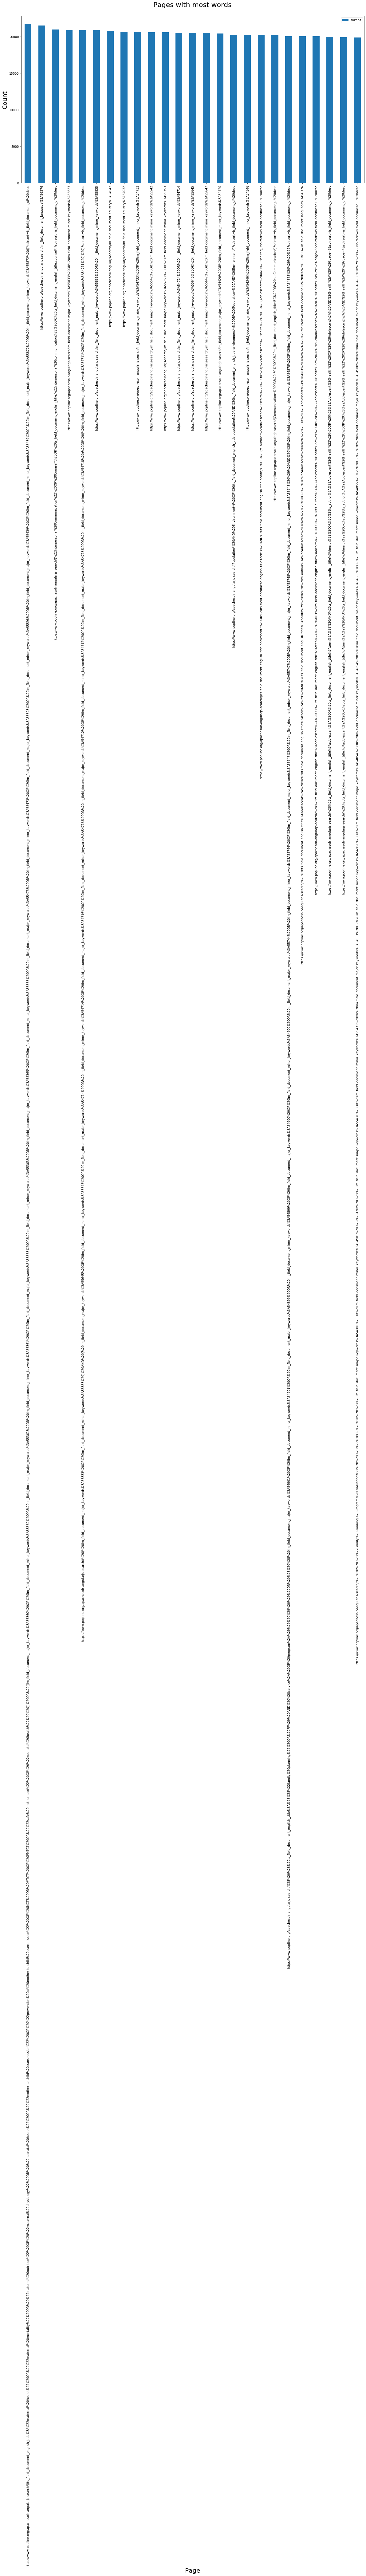

In [24]:
word_count_chart = word_count_df.plot(kind='bar', x='url', figsize=(20,10))
word_count_chart.set_title('Pages with most words\n', fontsize=22)
word_count_chart.set_ylabel('Count', fontsize=20)
word_count_chart.set_xlabel('Page', fontsize=20)

## How about NER on the two pages with the most tokens?

[Named-Entity Recognition](https://en.wikipedia.org/wiki/Named-entity_recognition), or NER, is an exciting field of natural language processing that lets us extract "entities" out of text. This might be the names of people, locations, or organizations. 

To do this, we first need to find the pages that have the most tokens.

In [0]:
pd.set_option('display.max_colwidth', -1)

In [26]:
word_count_max = pages_pd[['url', 'tokens', "content"]].sort_values(by='tokens', ascending=False).head(1)
word_count_max['url']

33164    https://www.popline.org/apachesolr-angularjs-search/((ts_field_document_english_title%3A%22maternal%20health%22%20OR%20%22maternal%20mortality%22%20OR%20%22maternal%20nutrition%22%20OR%20%22maternal%20physiology%22%20OR%20%22neonatal%20health%22%20OR%20%22mother-to-child%20transmission%22%20OR%20%22prevention%20of%20mother-to-child%20transmission%22%20OR%20MCT%20OR%20MTCT%20OR%20PMTCT%20OR%20%22safe%20motherhood%22%20OR%20%22neonatal%20health%22%20%20))%20OR%20((im_field_document_major_keywords%3A55360%20OR%20im_field_document_minor_keywords%3A55360%20OR%20im_field_document_major_keywords%3A55361%20OR%20im_field_document_minor_keywords%3A55361%20OR%20im_field_document_major_keywords%3A55363%20OR%20im_field_document_minor_keywords%3A55363%20OR%20im_field_document_major_keywords%3A55365%20OR%20im_field_document_minor_keywords%3A55365%20OR%20im_field_document_major_keywords%3A55473%20OR%20im_field_document_minor_keywords%3A55473%20OR%20im_field_document_major_keywords%3A55598%20O

Since these are both the same url, let's just stick with one to keep things simple here.

In [27]:
page = word_count_max['content'].astype('unicode').to_string()
page

"33164    POPLINE.org Skip to main content Translate: Select LanguageEnglishArabicCzechFrenchGermanGreekHebrewHindiItalianJapaneseKoreanPortugueseRussianSpanishTurkishVietnamese Keyword Guide Sign In Home Advanced Search Topics Services About Help MY BASKET MY DOCUMENTS Important: The POPLINE website will retire on September 1, 2019. Click here to read about the transition. Sort By: Relevancy Most Recent Your search found 37411 Results 1 399018 Delivery of Multiple Child and Maternal Health Interventions during Supplementary Immunization Campaign in Rwanda, 2013: Lessons Learnt. Sibomana H; Jered M; Rugambawa C; Chakauya JM; Shibeshi ME; Okeibunor J; Mihigo R; Bhaskar R Journal of Immunological Sciences. 2018 Aug 2; Suppl(9):63-67. View Abstract \xa0 Objective: This paper assesses and describes the estimated coverage of the Measles Rubella (MR) campaign in each district; the national estimate of coverage for Human Papilloma Virus (HPV) vaccination campaign and Vitamin A supplementation

### Setup spaCy

We now need to set up [spaCy](https://en.wikipedia.org/wiki/SpaCy), a natural-language processing toolkit. 

After installing it, the command will run NER on the text. Watch how it finds organizations, people, and beyond!

In [0]:
import spacy
from spacy import displacy

import en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [29]:
ner = nlp(page)
displacy.render(ner, style='ent', jupyter=True)

### Word Cloud

Word clouds are always fun, right?! They're an interesting way to visualize word frequency, as the more times that a word occurs, the larger it will appear in the word cloud.

Let's setup some dependencies here. We will install the [`word_cloud`](https://github.com/amueller/word_cloud) library, and setup some stop words via `nltk`.

In [0]:
%%capture

!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [0]:
wordcloud = WordCloud(width=2000, height=1500, scale=10, max_font_size=250, max_words=100, background_color="white").generate((pages_pd['tokenized_content_filtered']).to_string())
plt.figure(figsize=[35,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 44104)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/content/spark-2.4.5-bin-hadoop2.7/python/pyspark/accumulators.py", line 269, in handle
    poll(accum_updates)
  File "/content/spark-2.4.5-bin-hadoop2.7/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/content/spark-2.4.5-bin-hadoop2.7/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File